# Seq2Seq encoder decoder model with attention for translating english sentences to hindi 🥳  

#### Importing the prerequisites

In [1]:
import re
import nltk
import time
import spacy
import torch
import pickle
import random
import kagglehub
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

random_seed = 143

### Importing the dataset
Dataset used : [IITB English to Hindi parallel Corpus](https://www.cfilt.iitb.ac.in/iitb_parallel/)

Consists of around 1.5 Million English sentences with their Hindi translations

In [2]:
path = kagglehub.dataset_download("vaibhavkumar11/hindi-english-parallel-corpus")
data_path = "/kaggle/input/hindi-english-parallel-corpus/hindi_english_parallel.csv"

enhi_df = pd.read_csv(data_path)

print(f"First 5 data rows: {enhi_df.head(5)}")
print(f"Shape of data frame: {enhi_df.shape}")

First 5 data rows:                                                hindi  \
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक   
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका   
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका   
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...   

                                          english  
0  Give your application an accessibility workout  
1               Accerciser Accessibility Explorer  
2  The default plugin layout for the bottom panel  
3     The default plugin layout for the top panel  
4  A list of plugins that are disabled by default  
Shape of data frame: (1561841, 2)


In [3]:
en_sents0 = enhi_df.loc[:,"english"]
en_sents = [str(x) for x in en_sents0]
hi_sents0 = enhi_df.loc[:,"hindi"]
hi_sents = [str(x) for x in hi_sents0]

Seeing how long the sentences are in the dataset

In [4]:
token_count_en = []
token_count_hi = []

for eng, hin in zip(en_sents, hi_sents):
    token_count_en.append(len(eng.split()))
    token_count_hi.append(len(hin.split()))

print(f"Mean length of English sentences {sum(token_count_en) / len(token_count_en)}")
print(f"Mean length of Hindi sentences {sum(token_count_hi) / len(token_count_hi)}")

Mean length of English sentences 12.709731016153373
Mean length of Hindi sentences 13.702174549137844


In [5]:
enhi_pairs = list({"en":en, "hi":hi} for en, hi in zip(en_sents, hi_sents))
enhi_pairs[0]

{'en': 'Give your application an accessibility workout',
 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}

The data seems to be nicely paired and well made

In [6]:
def split_data(data, train_size, valid_size, test_size, seed = random_seed):
    assert train_size + valid_size + test_size == 100, \
        "sizes does not add up to 100"
    
    rng = np.random.default_rng(seed)
    data = data.copy()
    rng.shuffle(data)
    
    train_i = int(len(data) * (train_size/100))
    valid_i = int(len(data) * (valid_size/100))

    train_data = data[:train_i]
    valid_data = data[train_i : train_i + valid_i]
    test_data = data[train_i + valid_i :]

    print(f"Length of training data {len(train_data)}")
    print(f"Length of validation data {len(valid_data)}")
    print(f"Length of test data {len(test_data)}")
  
    return train_data, valid_data, test_data

In [7]:
# train_size = 150_000
# valid_size = 40_000
# test_size = 15_000

train_size = 70
valid_size = 20
test_size = 10

train_data, valid_data, test_data = split_data(enhi_pairs, train_size, valid_size, test_size)

Length of training data 1093288
Length of validation data 312368
Length of test data 156185


In [8]:
train_data[5]

{'en': 'hypnotized', 'hi': 'वशीभूत'}

In [24]:
en_nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r'\$.*?\$', '', text)
    punctuation = [
        "।", ",", "?",".","\"",
        "'", ":", ";", "(", ")",
        "[", "]", "{", "}","-",
        "!", "/", "\\", "*"]
    for p in punctuation:
        text = text.replace(p, " ")
    text = " ".join(text.split())
    return text

def tokenize(sample, en_nlp, max_len, sos_token, eos_token):
  en_tokens = [token.text for token in en_nlp.tokenizer(clean_text(sample["en"]))][:max_len]
  hi_tokens = clean_text(sample["hi"]).split()[:max_len]

  en_tokens = [token.lower() for token in en_tokens]
  hi_tokens = [token.lower() for token in hi_tokens]

  en_tokens = [sos_token] + en_tokens + [eos_token]
  hi_tokens = [sos_token] + hi_tokens + [eos_token]

  return {"en":en_tokens, "hi":hi_tokens}

def make_token_pairs(data, en_nlp, max_len, sos_token, eos_token):
    data_pairs = []
    for d in tqdm(data):
        data_pairs.append(
            tokenize(
                d,
                en_nlp,
                max_len,
                sos_token,
                eos_token
            )
        )
        
    return data_pairs

In [10]:
sos_token = "<sos>"
eos_token = "<eos>"
max_len = 20

train_token_pairs = make_token_pairs(train_data, en_nlp, max_len, sos_token, eos_token)
valid_token_pairs = make_token_pairs(valid_data, en_nlp, max_len, sos_token, eos_token)
test_token_pairs  = make_token_pairs(test_data, en_nlp, max_len, sos_token, eos_token)

print(f"{train_token_pairs[0]}")
print(f"{valid_token_pairs[0]}")
print(f"{test_token_pairs[0]}")

  0%|          | 0/1093288 [00:00<?, ?it/s]

  0%|          | 0/312368 [00:00<?, ?it/s]

  0%|          | 0/156185 [00:00<?, ?it/s]

{'en': ['<sos>', 'provisional', 'list', '<eos>'], 'hi': ['<sos>', 'अनंतिम', 'सूची', '<eos>']}
{'en': ['<sos>', 'category', 'crime', '<eos>'], 'hi': ['<sos>', 'श्रेणीःअपराध', '<eos>']}
{'en': ['<sos>', 'o', 'truthful', 'joseph', 'he', 'said', 'tell', 'us', 'the', 'meaning', 'of', 'a', 'dream', 'in', 'which', 'seven', 'fat', 'cows', 'are', 'being', 'eaten', '<eos>'], 'hi': ['<sos>', 'यूसुफ़', 'ऐ', 'सत्यवान', 'हमें', 'इसका', 'अर्थ', 'बता', 'कि', 'सात', 'मोटी', 'गायें', 'है', 'जिन्हें', 'सात', 'दुबली', 'गायें', 'खा', 'रही', 'है', 'और', '<eos>']}


In [11]:
def make_vocab(tokens, min_freq, special_tokens):
  en_freq, hi_freq, en_vocab, hi_vocab, en_rev, hi_rev = {},{},{},{},{},{}

  for enhi_pair in tokens:
    for token in enhi_pair["en"]:
      en_freq[token] = en_freq.get(token, 0) + 1
    for token in enhi_pair["hi"]:
      hi_freq[token] = hi_freq.get(token, 0) + 1

  en_freq = dict(sorted(en_freq.items(), key=lambda x: x[1], reverse=True))
  hi_freq = dict(sorted(hi_freq.items(), key=lambda x: x[1], reverse=True))

  for i, sptokens in enumerate(special_tokens):
    en_vocab[sptokens] = i
    hi_vocab[sptokens] = i

  i = len(special_tokens)
  for key, val in hi_freq.items():
    if val > min_freq and key not in special_tokens:
      hi_vocab[key] = i
      i += 1

  i = len(special_tokens)
  for key, val in en_freq.items():
    if val > min_freq and key not in special_tokens:
      en_vocab[key] = i
      i += 1

  for key, val in en_vocab.items():
    en_rev[val] = key
  for key, val in hi_vocab.items():
    hi_rev[val] = key

  return en_vocab, en_rev, hi_vocab, hi_rev

In [12]:
min_freq = 58
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab, en_rev, hi_vocab, hi_rev = make_vocab(
    tokens=train_token_pairs,
    min_freq=min_freq,
    special_tokens=special_tokens,
           )

In [13]:
len(en_vocab), len(en_rev), len(hi_vocab), len(hi_rev)

(11056, 11056, 11487, 11487)

In [27]:
with open("/kaggle/working/en_vocab.pkl","wb") as f:
    pickle.dump(en_vocab, f)
with open("/kaggle/working/hi_vocab.pkl","wb") as f:
    pickle.dump(hi_vocab, f)

In [8]:
# Load vocab if initialized
with open("/kaggle/input/loss-list-and-vocabulary/en_vocab.pkl", "rb") as f:
    en_vocab = pickle.load(f)
with open("/kaggle/input/loss-list-and-vocabulary/hi_vocab.pkl", "rb") as f:
    hi_vocab = pickle.load(f)

en_rev = {val:key for key, val in en_vocab.items()}
hi_rev = {val:key for key, val in hi_vocab.items()}

len(en_vocab), len(en_rev), len(hi_vocab), len(hi_rev)

(11056, 11056, 11487, 11487)

In [ ]:
unk_index = en_vocab["<unk>"]
pad_index = en_vocab["<pad>"]

def encode(sample, en_vocab, hi_vocab, pad_index=pad_index, max_len=max_len + 2):
  en_encoded, hi_encoded = [], []
  for en_token in sample["en"]:
    en_encoded.append(en_vocab.get(en_token, 0))
  for hi_token in sample["hi"]:
    hi_encoded.append(hi_vocab.get(hi_token, 0))

  while len(en_encoded) < max_len:
    en_encoded.append(pad_index)
  while len(hi_encoded) < max_len:
    hi_encoded.append(pad_index)

  return {"en":en_encoded, "hi":hi_encoded}

def encode_pairs(data, en_vocab, hi_vocab):
    data_ids = []
    for pair in tqdm(data):
        data_ids.append(
            encode(
                pair,
                en_vocab,
                hi_vocab
            )
        )
    return data_ids

In [ ]:
train_ids = encode_pairs(train_token_pairs, en_vocab, hi_vocab)
valid_ids = encode_pairs(valid_token_pairs, en_vocab, hi_vocab)
test_ids = encode_pairs(test_token_pairs, en_vocab, hi_vocab)

print(f"{train_ids[0]}")
print(f"{valid_ids[0]}")
print(f"{test_ids[0]}")

In [16]:
def count_unk(data):
  unk = 0
  for d in data:
    unk += d["en"].count(0)
    unk += d["hi"].count(0)

  print((unk / (len(data) * 2 * 22)) * 100)
  
count_unk(train_ids)
count_unk(valid_ids)
count_unk(test_ids)

3.856949695031701
3.889599330393522
3.8926884493040013


In [17]:
def get_dataloader(dataset, batch_size, shuffle = False):
  en_sents, hi_sents = [],[]
  for pair in dataset:
    en_sents.append(pair["en"])
    hi_sents.append(pair["hi"])

  en_sents = torch.tensor(en_sents, dtype=torch.long)
  hi_sents = torch.tensor(hi_sents, dtype=torch.long)

  dataset_new = torch.utils.data.TensorDataset(en_sents, hi_sents)
  dataloader = torch.utils.data.DataLoader(
      dataset = dataset_new,
      batch_size = batch_size,
      shuffle = shuffle,
  )
  print(f"Made a dataloader of size {len(dataloader)}")
  return dataloader

In [18]:
batch_size = 128

train_dloader = get_dataloader(
    dataset=train_ids,
    batch_size = batch_size,  )

valid_dloader = get_dataloader(
    dataset=valid_ids,
    batch_size = batch_size,  )

test_dloader = get_dataloader(
    dataset=test_ids,
    batch_size = batch_size, )

Made a dataloader of size 8542
Made a dataloader of size 2441
Made a dataloader of size 1221


In [10]:
class Encoder(nn.Module):
  def __init__(self, en_vocab_size, embed_dim, encoder_hidden_dim, decoder_hidden_dim, dropout):
    super().__init__()
    self.embedding = nn.Embedding(en_vocab_size, embed_dim)
    self.gru = nn.GRU(embed_dim, encoder_hidden_dim, bidirectional=True)
    self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input):
    # input shape : [input_len , batch_size]
    embedding = self.dropout(self.embedding(input))
    # embed shape : [input_len, batch_size, embed_dim]
    outputs, hidden = self.gru(embedding)
    # outputs shape : [input_len, batch_size, hidden_dim * n_directions]
    # hidden shape : [n_layers * n_directions, batch_size, hidden_dim]
    hidden = torch.tanh(
        self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    )
    # outputs shape : [input_len, batch_size, encoder_hidden_dim * 2]
    # hidden shape : [batch_size, decoder_hidden_dim]
    return outputs, hidden

In [11]:
class Attention(nn.Module):
  def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
    super().__init__()
    self.attn_fc = nn.Linear(
        (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
    )
    self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

  def forward(self, hidden, encoder_outputs):
    # hidden shape : [batch_size, decoder_hidden_dim]
    # encoder_outputs : [input_len, batch_size, encoder_hidden_dim * 2]
    batch_size = encoder_outputs.shape[1]
    input_len = encoder_outputs.shape[0]

    hidden = hidden.unsqueeze(1).repeat(1, input_len, 1)
    encoder_outputs = encoder_outputs.permute(1,0,2)
    # hidden shape : [batch_size, input_len, decoder_hidden_dim]
    # encoder_outputs shape : [batch_size, input_len, encoder_hidden_dim * 2]
    energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim = 2)))
    # energy shape : [batch_size, input_len, decoder_hidden_dim]
    attention = self.v_fc(energy).squeeze(2)
    # attention shape : [batch_size, input_len]
    return torch.softmax(attention, dim = 1)

In [12]:
class Decoder(nn.Module):
  def __init__(self, hi_vocab_size, embed_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention):
    super().__init__()
    self.hi_vocab_size = hi_vocab_size
    self.attention = attention
    self.embedding = nn.Embedding(hi_vocab_size, embed_dim)
    self.gru = nn.GRU((encoder_hidden_dim * 2) + embed_dim, decoder_hidden_dim)
    self.fc_out = nn.Linear(
        (encoder_hidden_dim * 2) + decoder_hidden_dim + embed_dim, hi_vocab_size
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, encoder_outputs):
    # input shape : [batch_size]
    # hidden shape : [batch_size, decoder_hidden_dim]
    # encoder_outputs shape : [input_len, batch_size, encoder_hidden_dim * 2]
    input = input.unsqueeze(0)
    # input shape : [1, batch_size]
    embed = self.dropout(self.embedding(input))
    # embed shape : [1, batch_size, embed_dim]
    a = self.attention(hidden, encoder_outputs)
    # a shape : [batch_size, input_len]
    a = a.unsqueeze(1)
    # a shape : [batch_size, 1, input_len]
    encoder_outputs = encoder_outputs.permute(1,0,2)
    # encoder_outputs shape : [batch_size, input_len, encoder_hidden_dim * 2]
    weighted = torch.bmm(a, encoder_outputs)
    weighted = weighted.permute(1,0,2)
    # weighted shape : [1, batch_size, encoder_hidden_dim * 2]
    gru_input = torch.cat((embed, weighted), dim = 2)
    # gru_input shape : [1, batch_size, (encoder_hidden_dim * 2) + embed_dim]
    output, hidden = self.gru(gru_input, hidden.unsqueeze(0))
    # output shape : [1, batch_size, decoder_hidden_dim]
    # hidden shape : [1, batch_size, decoder_hidden_dim]
    assert(output == hidden).all()
    embed = embed.squeeze(0)
    output = output.squeeze(0)
    weighted = weighted.squeeze(0)
    prediction = self.fc_out(torch.cat((output, weighted, embed), dim = 1))
    # prediction shape : [batch_size, hi_vocab_size]
    return prediction, hidden.squeeze(0), a.squeeze(1)

In [13]:
class seq2seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, input, target, teacher_forcing_ratio):
    # input shape : [batch_size, input_len]
    # target shape : [batch_size, target_len]
    # teacher_forcing_ratio is the probability to do teacher forcing
    batch_size = target.shape[1]
    target_len = target.shape[0]
    hi_vocab_size = self.decoder.hi_vocab_size

    outputs = torch.zeros(target_len, batch_size, hi_vocab_size).to(self.device).to(self.device)
    encoder_outputs, hidden = self.encoder(input)
    decoder_input = target[0, :]

    for t in range(1, target_len):
      output, hidden, _ = self.decoder(decoder_input, hidden, encoder_outputs)
      outputs[t] = output
      teacher_force = random.random() < teacher_forcing_ratio
      top1 = output.argmax(1)
      decoder_input = target[t] if teacher_force else top1

    return outputs

In [14]:
en_vocab_size = len(en_vocab)
hi_vocab_size = len(hi_vocab)
encoder_embed_dim = 256
decoder_embed_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.3
decoder_dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    en_vocab_size,
    encoder_embed_dim,
    encoder_hidden_dim, 
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    hi_vocab_size,
    decoder_embed_dim,
    encoder_hidden_dim, 
    decoder_hidden_dim,
    decoder_dropout,
    attention
)

model = seq2seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = pad_index)

print(f"Using {device}")

Using cpu


In [15]:
def init_weights(model):
  for name, param in model.named_parameters():
    if "weight" in name:
      nn.init.normal_(param.data, mean=0, std=0.01)
            
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
print(f"The model has {count_parameters(model):,} trainable parameters")
model.apply(init_weights)

The model has 32,800,479 trainable parameters


seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(11056, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(11487, 256)
    (gru): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=11487, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [19]:
# Load the model if trained

with open("/kaggle/input/loss-list-and-vocabulary/train_plot.pkl", "rb") as f:
    train_plot = pickle.load(f)

with open("/kaggle/input/loss-list-and-vocabulary/valid_plot.pkl", "rb") as f:
    valid_plot = pickle.load(f)

state_dict = torch.load("/kaggle/input/seq2seq-model/pytorch/default/1/seq2seq_attn.pth", map_location = device)
model.load_state_dict(state_dict)
model.eval()

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(11056, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(11487, 256)
    (gru): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=11487, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [20]:
def train_epoch(
    model,
    dataloader,
    optimizer,
    criterion,
    clip,
    teacher_forcing_ratio,
    device
    ):
  model.train()
  running_loss = 0
  for eng, hin in tqdm(dataloader):
    eng = eng.permute(1,0).to(device)
    hin = hin.permute(1,0).to(device)
    # eng shape : [eng_len, batch_size]
    # hin shape : [hin_len, batch_size]
    optimizer.zero_grad()
    output = model(eng, hin, teacher_forcing_ratio)
    # output shape : [hin_len, batch_size, hi_vocab_size]
    output_dim = output.shape[-1]
    output = output[1:].reshape(-1, output_dim)
    # output shape : [(hin_len - 1) * batch_size, hi_vocab_size]
    hin = hin[1:].reshape(-1)
    # hin shape : [(hin_len - 1) * batch_size]
    loss = criterion(output, hin)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    running_loss += loss.item()
  return running_loss / len(dataloader)

def eval_epoch(
    model,
    dataloader,
    criterion,
    device
    ):
  model.eval()
  running_loss = 0
  with torch.no_grad():
    for eng, hin in tqdm(dataloader):
      eng = eng.permute(1,0).to(device)
      hin = hin.permute(1,0).to(device)
      # eng shape : [eng_len, batch_size]
      # hin shape : [hin_len, batch_size]
      output = model(eng, hin, 0)
      # output shape : [hin_len, batch_size, hi_vocab_size]
      output_dim = output.shape[-1]
      output = output[1:].reshape(-1, output_dim)
      # output shape : [(hin_len - 1) * batch_size, hi_vocab_size]
      hin = hin[1:].reshape(-1)
      # hin shape : [(hin_len - 1) * batch_size]
      loss = criterion(output, hin)
      running_loss += loss.item()
  return running_loss / len(dataloader)

In [30]:
torch.manual_seed(235)

clip = 1
epochs = 10
teacher_forcing_ratio = 0.5

train_losses = []
valid_losses = []

best_valid_loss = float("inf")

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}", end = " | ")
    train_loss = train_epoch(
        model,
        train_dloader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device
    )
    valid_loss = eval_epoch(
        model,
        valid_dloader,
        criterion,
        device
    )
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f"Train Loss -> {train_loss:.3f}")
    print(f"Valid Loss -> {valid_loss:.3f}")
    
    if valid_loss < best_valid_loss:
        print(f"Found new best validation loss")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "/kaggle/working/seq2seq_attn.pth")

Epoch 1/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 4.126
Valid Loss -> 4.258
Found new best validation loss
Epoch 2/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 3.439
Valid Loss -> 4.145
Found new best validation loss
Epoch 3/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 3.235
Valid Loss -> 4.138
Found new best validation loss
Epoch 4/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 3.103
Valid Loss -> 4.099
Found new best validation loss
Epoch 5/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 3.022
Valid Loss -> 4.080
Found new best validation loss
Epoch 6/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 2.949
Valid Loss -> 4.090
Epoch 7/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 2.888
Valid Loss -> 4.076
Found new best validation loss
Epoch 8/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 2.846
Valid Loss -> 4.066
Found new best validation loss
Epoch 9/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 2.808
Valid Loss -> 4.079
Epoch 10/10 | 

  0%|          | 0/8542 [00:00<?, ?it/s]

  0%|          | 0/2441 [00:00<?, ?it/s]

Train Loss -> 2.773
Valid Loss -> 4.083


In [140]:
train_plot += train_losses
valid_plot += valid_losses

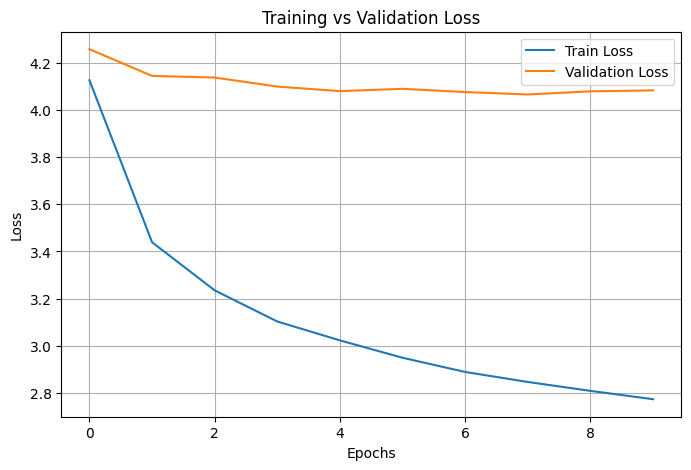

In [29]:
plt.figure(figsize=(8, 5))

plt.plot(train_plot, label="Train Loss")
plt.plot(valid_plot, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

plt.legend()
plt.grid(True)

plt.savefig("loss_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [62]:
with open("/kaggle/working/train_plot.pkl","wb") as f:
    pickle.dump(train_plot, f)
with open("/kaggle/working/valid_plot.pkl","wb") as f:
    pickle.dump(valid_plot, f)

In [67]:
train_plot

[4.126189641024742,
 3.438774898581973,
 3.2345890294916595,
 3.1025034840116454,
 3.022401518214366,
 2.948669220993151,
 2.8884194793201,
 2.846000990301573,
 2.8081941991744404,
 2.7727776476382875]

In [68]:
valid_plot

[4.257916515062012,
 4.144615638944664,
 4.137760497663217,
 4.099356046029653,
 4.080126022716274,
 4.089954581821321,
 4.076223826515826,
 4.065854729125364,
 4.079246131282808,
 4.083307189367092]

In [26]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    en_vocab,
    hi_vocab,
    hi_rev,
    sos_token,
    eos_token,
    device,
    max_output_length = 25,
    temperature = 1.0,
    ):
  model.eval()
  with torch.no_grad():
    if isinstance(sentence, str):
      tokens = [token.text for token in en_nlp.tokenizer(clean_text(sentence))]
    else:
      tokens = [token for token in sentence]

    tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]

    ids = []
    for token in tokens:
      ids.append(en_vocab.get(token, 0))

    tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
    encoder_outputs, hidden = model.encoder(tensor)

    inputs = [hi_vocab[sos_token]]

    attentions = torch.zeros(max_output_length, 1, len(ids))

    for i in range(max_output_length):
      inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
      output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
      attentions[i] = attention
      predicted_token = output.argmax(-1).item()
      inputs.append(predicted_token)
      if predicted_token == hi_vocab[eos_token]:
        break

    tokens = []
    for id in inputs:
      tokens.append(hi_rev.get(id, "<unk>"))

  return " ".join(tokens[1:-1])

def translate_sentence_2(
    sentence,
    model,
    en_nlp,
    en_vocab,
    hi_vocab,
    hi_rev,
    sos_token,
    eos_token,
    device,
    max_output_length = 25,
    temperature = 1.0,
    ):
  model.eval()
  with torch.no_grad():
    if isinstance(sentence, str):
      tokens = [token.text for token in en_nlp.tokenizer(clean_text(sentence))]
    else:
      tokens = [token for token in sentence]

    tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]

    ids = [en_vocab.get(tok, 0) for tok in tokens]

    tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
    encoder_outputs, hidden = model.encoder(tensor)

    inputs = [hi_vocab[sos_token]]

    attentions = torch.zeros(max_output_length, 1, len(ids))

    for i in range(max_output_length):
      inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
      output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)

      # APPLY TEMPERATURE + MULTINOMIAL SAMPLING 🎲🔥
      probs = torch.softmax(output.squeeze() / temperature, dim=-1)
      predicted_token = torch.multinomial(probs, 1).item()

      inputs.append(predicted_token)
      attentions[i] = attention

      if predicted_token == hi_vocab[eos_token]:
        break

    tokens = [hi_rev.get(id, "<unk>") for id in inputs]

  return " ".join(tokens[1:-1])


def translate(sentence, model, random_true = True, temperature = 0.1):
    if random_true:
        i = np.random.randint(0, len(test_data))
        sentence = test_data[i]["en"]
        translation = test_data[i]["hi"]
    
    model_translation = translate_sentence_2(
        sentence = sentence,
        model = model,
        en_nlp = en_nlp,
        hi_vocab = hi_vocab,
        en_vocab = en_vocab,
        hi_rev = hi_rev,
        sos_token = "<sos>",
        eos_token = "<eos>",
        device = device,
        temperature=temperature,
        )

    if random_true:
        print(f"English sentence -> {sentence}\nHindi translation -> {translation}\nModel translation -> {model_translation}")
    else:
        print(f"English sentence -> {sentence}\nModel translation -> {model_translation}")

    print("-" * 50)
    

In [27]:
translate("the girl", model, random_true=False)
translate("the boy", model, random_true=False)
translate("my india", model, random_true=False)
translate("not my america", model, random_true=False)
translate("the party never stops", model, random_true=False)
translate("i love you", model, random_true=False)
translate("i did it", model, random_true=False)
translate("you are so beautiful", model, random_true=False)

English sentence -> the girl
Model translation -> लड़की ने लड़की लड़की लड़की को लड़की लड़की की लड़की को <unk> लड़की की <unk> लड़की
--------------------------------------------------
English sentence -> the boy
Model translation -> लड़के का लड़का जिसको <unk> <unk> है तो लड़के ने लड़के को <unk> किया
--------------------------------------------------
English sentence -> my india
Model translation -> भारत भारत की <unk> भारत के इजराइल के भारत के मेरा हार्दिक बधाई देता हूं
--------------------------------------------------
English sentence -> not my america
Model translation -> न अमेरिका अमेरिका के <unk> अमेरिका के <unk> अमेरिका के अमरीका में नहीं है
--------------------------------------------------
English sentence -> the party never stops
Model translation -> पार्टी कभी कभी रोक नहीं नहीं नहीं कभी कभी नहीं रोक नहीं नहीं है
--------------------------------------------------
English sentence -> i love you
Model translation -> मैं तुम्हें प्यार करता हूँ और प्यार करता हूँ तो प्यार करता हूँ
---

In [28]:
translate("this is my country", model, random_true=False, temperature = 0.7)

English sentence -> this is my country
Model translation -> यह मेरा देश देश <unk> है और होना देश देश देश देश के उसका देश है जिसे मेरी देश है
--------------------------------------------------


In [104]:
model_translations = [
  translate_sentence(
        sentence = pairs["en"],
        model = model,
        en_nlp = en_nlp,
        hi_vocab = hi_vocab,
        en_vocab = en_vocab,
        hi_rev = hi_rev,
        sos_token = sos_token,
        eos_token = eos_token,
        device = device,
        temperature=0.7,
        )
  for pairs in tqdm(test_data[:5000])
  ]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [105]:
model_translations_list = [sent.split() for sent in model_translations]
actual_translations_list = [sent["hi"].split() for sent in test_data[:5000]]

In [106]:
len(model_translations_list), len(actual_translations_list)

(5000, 5000)

In [139]:
bleu_score = corpus_bleu(
    [[ref] for ref in actual_translations_list],
    model_translations_list
)
print(f"BLEU score : {bleu_score}")

BLEU score : 0.05859247471432541
